In [1]:
%load_ext autoreload
%autoreload 2

In [87]:
import numpy as np
import pandas as pd

import csv as csv
import sklearn
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm as lgb

from utils import save_to_csv, reduce_memory_usage,custom_kfold_scorer 

In [88]:
train_df = pd.read_csv("./train_2.csv")
test_df = pd.read_csv("./test_2.csv")
aux_df = pd.read_csv("./auxiliary-data/sg-commerical-centres.csv")

In [89]:
aux_df.head()

,name,type,lat,lng
0,Central Business District,CR,1.286768,103.854529
1,Jurong Lake District,CR,1.334085,103.734513
2,Seletar Regional Centre,CR,1.409435,103.866820
3,Tampines Regional Centre,CR,1.353180,103.945188
4,Woodlands Regional Centre,CR,1.436748,103.786485


## Check for NULL values

In [90]:
aux_df.isnull().any()

name    False
type    False
lat     False
lng     False
dtype: bool

### Checking for duplicate values

In [91]:
aux_df.duplicated().any()

False

## Distribution of HDB flats and Commercial centers

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

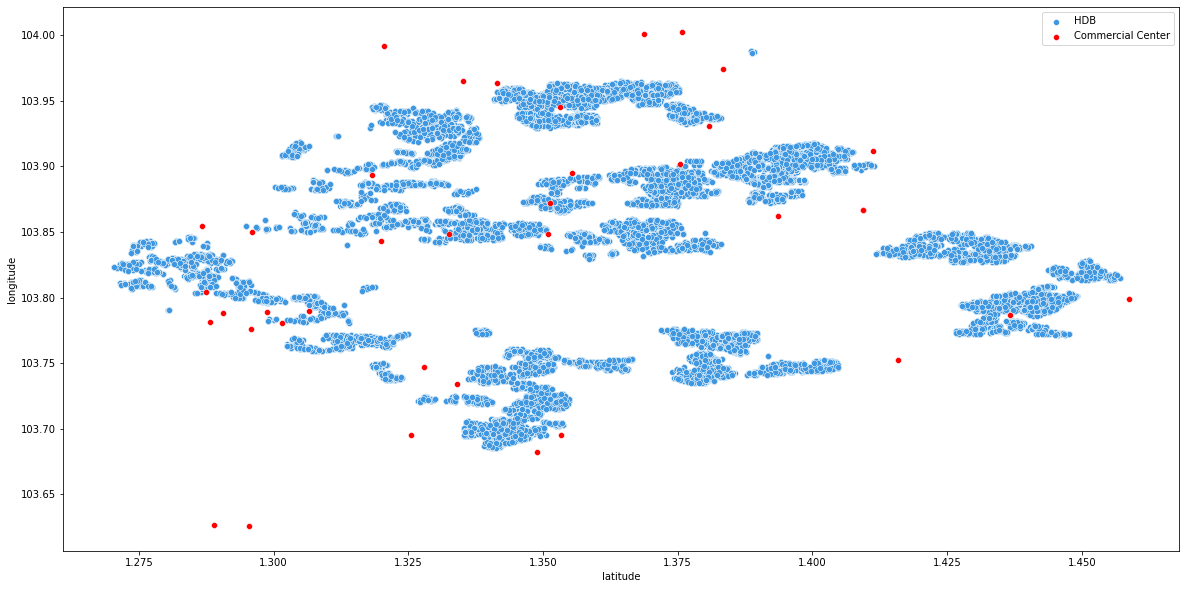

In [92]:
plt.figure(figsize=(20,10))
sns.scatterplot(y=train_df.longitude,x=train_df.latitude,color="#3E97E0",label="HDB")
sns.scatterplot(y=aux_df.lng,x=aux_df.lat,color="red",label="Commercial Center")

### Club latitude and longitude together and drop 'lat' and 'lng' columns

In [93]:
aux_df['lat_long'] = list(zip(aux_df.lat, aux_df.lng))

In [94]:
aux_df = aux_df.drop(columns=['lat','lng'])

In [95]:
aux_df.head()

,name,type,lat_long
0,Central Business District,CR,"(1.286768414387322, 103.85452859811022)"
1,Jurong Lake District,CR,"(1.3340851937252969, 103.73451290700358)"
2,Seletar Regional Centre,CR,"(1.40943507375581, 103.866819823979)"
3,Tampines Regional Centre,CR,"(1.353180098998845, 103.94518782505514)"
4,Woodlands Regional Centre,CR,"(1.4367480296002553, 103.78648452433363)"


### Extract lat_long and year from train and test data sets

In [96]:
train_df_temp = train_df[["lat_long"]]
test_df_temp = test_df[["lat_long"]]

### Drop duplicate locations

In [97]:
train_df_temp = train_df_temp.drop_duplicates(subset=['lat_long'])
test_df_temp = test_df_temp.drop_duplicates(subset=['lat_long'])

### Add columns to store the nearest commercial center and its distance and number of commercial centers in 1km

In [98]:
train_df_temp["nearest_commercial_center"] = str("--")
train_df_temp["nearest_commercial_center_distance"] = math.inf
train_df_temp["commercial_center_1_km"] = 0
test_df_temp["nearest_commercial_center"] = str("--")
test_df_temp["nearest_commercial_center_distance"] = math.inf
test_df_temp["commercial_center_1_km"] = 0
train_df_temp = train_df_temp.reset_index()
test_df_temp = test_df_temp.reset_index()

In [99]:
aux_df = aux_df.drop(columns=['type'])
aux_df = aux_df.reset_index()

In [100]:
aux_df.head()

,index,name,lat_long
0,0,Central Business District,"(1.286768414387322, 103.85452859811022)"
1,1,Jurong Lake District,"(1.3340851937252969, 103.73451290700358)"
2,2,Seletar Regional Centre,"(1.40943507375581, 103.866819823979)"
3,3,Tampines Regional Centre,"(1.353180098998845, 103.94518782505514)"
4,4,Woodlands Regional Centre,"(1.4367480296002553, 103.78648452433363)"


In [101]:
train_df_temp.head()

,index,lat_long,nearest_commercial_center,nearest_commercial_center_distance,commercial_center_1_km
0,0,"(1.3690080642700195, 103.95869445800781)",--,inf,0
1,1,"(1.3990070819854736, 103.90699005126953)",--,inf,0
2,2,"(1.3883482217788696, 103.87381744384766)",--,inf,0
3,3,"(1.3184930086135864, 103.7667007446289)",--,inf,0
4,4,"(1.3481495380401611, 103.74266052246094)",--,inf,0


In [102]:
test_df_temp.head()

,index,lat_long,nearest_commercial_center,nearest_commercial_center_distance,commercial_center_1_km
0,0,"(1.3465807437896729, 103.74408721923828)",--,inf,0
1,1,"(1.3576176166534424, 103.96138000488281)",--,inf,0
2,2,"(1.337803840637207, 103.74199676513672)",--,inf,0
3,3,"(1.380083680152893, 103.84957122802734)",--,inf,0
4,4,"(1.3139597177505493, 103.76982879638672)",--,inf,0


Converting our dataframe to numpy arrays for faster computation

In [103]:
train_df_temp_numpy = train_df_temp.to_numpy()
test_df_temp_numpy = test_df_temp.to_numpy()
aux_df_numpy = aux_df.to_numpy()

In [104]:
print("Shape of train_df_temp_numpy :",np.shape(train_df_temp_numpy))
print("Shape of test_df_temp_numpy :",np.shape(test_df_temp_numpy))
print("Shape of aux_df_numpy :",np.shape(aux_df_numpy))

Shape of train_df_temp_numpy : (9138, 5)
Shape of test_df_temp_numpy : (8990, 5)
Shape of aux_df_numpy : (38, 3)


### Get the nearest commercial center and its distance from HDB. Also count the number of commercial centers within 1km from HDB

In [105]:
%%time
print("Get distance for each location and update nearest commercial center and its distance")
for i in range(len(train_df_temp_numpy)):
    min_dist = math.inf
    min_dist_aux = ""
    hdb_location = train_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    count = 0
    for j in range(len(aux_df_numpy)):
        aux_location = aux_df_numpy[j][2]
        distance = geopy.distance.great_circle(hdb_location, aux_location).km
        if distance < min_dist:
            min_dist = distance
            min_dist_mrt = aux_df_numpy[j][1]
        if distance <= 1:
            count+=1
    train_df_temp_numpy[i][2] = min_dist_mrt
    train_df_temp_numpy[i][3] = min_dist
    train_df_temp_numpy[i][4] = count

print("Add nearest_commercial_center and nearest_commercial_center_distance and count of shopping malls in 1 km to dataframe")
for i in range(len(train_df_temp_numpy)):
    dataframe_index = train_df_temp_numpy[i][0]
    train_df_temp.loc[i, "nearest_commercial_center"] = train_df_temp_numpy[i][2]
    train_df_temp.loc[i, "nearest_commercial_center_distance"] = train_df_temp_numpy[i][3]
    train_df_temp.loc[i, "commercial_center_1_km"] = train_df_temp_numpy[i][4]

Get distance for each location and update nearest commercial center and its distance
Add nearest_commercial_center and nearest_commercial_center_distance and count of shopping malls in 1 km to dataframe
Wall time: 9.03 s


In [106]:
%%time
print("Get distance for each location and update nearest shopping mall and its distance")
for i in range(len(test_df_temp_numpy)):
    min_dist = math.inf
    min_dist_aux = ""
    hdb_location = test_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    count = 0
    for j in range(len(aux_df_numpy)):
        aux_location = aux_df_numpy[j][2]
        distance = geopy.distance.great_circle(hdb_location, aux_location).km
        if distance < min_dist:
            min_dist = distance
            min_dist_mrt = aux_df_numpy[j][1]
        if distance <= 0.5:
            count+=1
    test_df_temp_numpy[i][2] = min_dist_mrt
    test_df_temp_numpy[i][3] = min_dist
    test_df_temp_numpy[i][4] = count

print("Add nearest_commercial_center and nearest_commercial_center_distance and count of shopping malls in half km to dataframe")
for i in range(len(test_df_temp_numpy)):
    dataframe_index = test_df_temp_numpy[i][0]
    test_df_temp.loc[i, "nearest_commercial_center"] = test_df_temp_numpy[i][2]
    test_df_temp.loc[i, "nearest_commercial_center_distance"] = test_df_temp_numpy[i][3]
    test_df_temp.loc[i, "commercial_center_1_km"] = test_df_temp_numpy[i][4]

Get distance for each location and update nearest shopping mall and its distance
Add nearest_commercial_center and nearest_commercial_center_distance and count of shopping malls in half km to dataframe
Wall time: 9.11 s


In [107]:
train_df_temp.head()

,index,lat_long,nearest_commercial_center,nearest_commercial_center_distance,commercial_center_1_km
0,0,"(1.3690080642700195, 103.95869445800781)",Tampines Regional Centre,2.313421,0
1,1,"(1.3990070819854736, 103.90699005126953)",Punggol Digital District,1.462459,0
2,2,"(1.3883482217788696, 103.87381744384766)",Sengkang West,1.445186,0
3,3,"(1.3184930086135864, 103.7667007446289)",International Business Park,2.387002,0
4,4,"(1.3481495380401611, 103.74266052246094)",Jurong Lake District,1.807230,0


In [108]:
test_df_temp.head()

,index,lat_long,nearest_commercial_center,nearest_commercial_center_distance,commercial_center_1_km
0,0,"(1.3465807437896729, 103.74408721923828)",Jurong Lake District,1.750241,0
1,1,"(1.3576176166534424, 103.96138000488281)",Singapore Univeristy of Technology and Design,1.819764,0
2,2,"(1.337803840637207, 103.74199676513672)",Jurong Lake District,0.929035,0
3,3,"(1.380083680152893, 103.84957122802734)",Sengkang West,2.027525,0
4,4,"(1.3139597177505493, 103.76982879638672)",Singapore Institute of Technology,1.827756,0


### We will now merge the result with our original data frames

In [109]:
temp = train_df_temp[["lat_long", "nearest_commercial_center", "nearest_commercial_center_distance","commercial_center_1_km"]]
train_df = pd.merge(train_df, temp, on="lat_long", how='left')

temp = test_df_temp[["lat_long", "nearest_commercial_center", "nearest_commercial_center_distance","commercial_center_1_km"]]
test_df = pd.merge(test_df, temp, on="lat_long", how='left')

### Nearest Commercial center and its distance from HDB has been added to our dataframe

In [110]:
train_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,resale_price,month_no,year,storey,lat_long,nearest_commercial_center,nearest_commercial_center_distance,commercial_center_1_km
0,pasir ris,4-room,440,pasir ris drive 4,118.0,model a,1989,1.369008,103.958694,pasir ris drive,pasir ris,east region,209700.0,8,2001,2.0,"(1.3690080642700195, 103.95869445800781)",Tampines Regional Centre,2.313421,0
1,punggol,5-room,196B,punggol field,110.0,improved,2003,1.399007,103.906990,punggol field,punggol,north-east region,402300.0,10,2014,11.0,"(1.3990070819854736, 103.90699005126953)",Punggol Digital District,1.462459,0
2,sengkang,5-room,404A,fernvale lane,112.0,premium apartment,2004,1.388348,103.873820,fernvale,sengkang,north-east region,351000.0,9,2020,2.0,"(1.3883482217788696, 103.87381744384766)",Sengkang West,1.445186,0
3,clementi,3-room,375,clementi avenue 4,67.0,new generation,1980,1.318493,103.766700,clementi north,clementi,west region,151200.0,10,2000,8.0,"(1.3184930086135864, 103.7667007446289)",International Business Park,2.387002,0
4,bukit batok,3-room,163,bukit batok street 11,73.0,model a,1985,1.348150,103.742660,bukit batok west,bukit batok,west region,318600.0,1,2013,8.0,"(1.3481495380401611, 103.74266052246094)",Jurong Lake District,1.807230,0


In [111]:
test_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,month_no,year,storey,lat_long,nearest_commercial_center,nearest_commercial_center_distance,commercial_center_1_km
0,bukit batok,4-room,186,bukit batok west avenue 6,94.0,new generation,1989,1.346581,103.74409,bukit batok west,bukit batok,west region,1,2004,5.0,"(1.3465807437896729, 103.74408721923828)",Jurong Lake District,1.750241,0
1,tampines,5-room,366,tampines street 34,122.0,improved,1997,1.357618,103.96138,tampines east,tampines,east region,11,2001,5.0,"(1.3576176166534424, 103.96138000488281)",Singapore Univeristy of Technology and Design,1.819764,0
2,jurong east,3-room,206,jurong east street 21,67.0,new generation,1982,1.337804,103.74200,toh guan,jurong east,west region,7,2002,2.0,"(1.337803840637207, 103.74199676513672)",Jurong Lake District,0.929035,0
3,ang mo kio,3-room,180,Ang Mo Kio Avenue 5,82.0,new generation,1981,1.380084,103.84957,yio chu kang east,ang mo kio,north-east region,4,2015,5.0,"(1.380083680152893, 103.84957122802734)",Sengkang West,2.027525,0
4,clementi,5-room,356,clementi avenue 2,117.0,standard,1978,1.313960,103.76983,clementi north,clementi,west region,4,2004,2.0,"(1.3139597177505493, 103.76982879638672)",Singapore Institute of Technology,1.827756,0


### Correlation between commercial_center and resale_price

<AxesSubplot:>

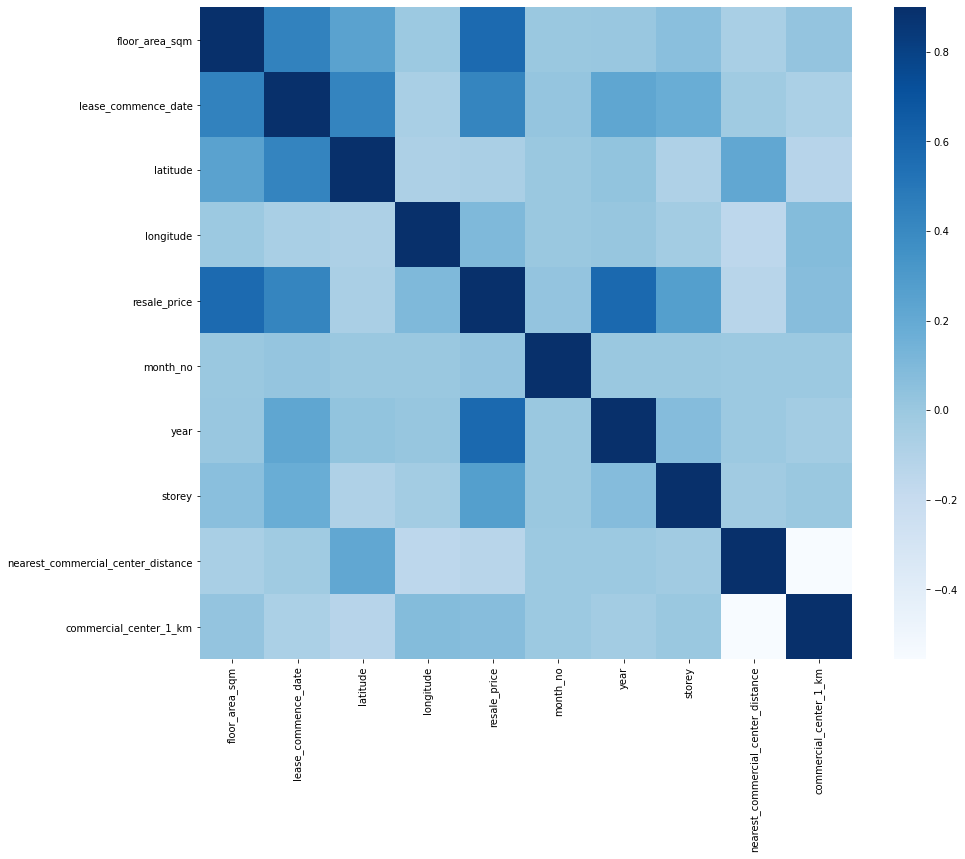

In [112]:
corr = train_df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [113]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False)[6:7].style.background_gradient(cmap='viridis', axis=None)

,resale_price
commercial_center_1_km,0.074196


In [114]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False)[9:].style.background_gradient(cmap='viridis', axis=None)

,resale_price
nearest_commercial_center_distance,-0.128550


### Reduce the size of dataframe to save memory during training

In [115]:
train_df, _ = reduce_memory_usage(train_df)
test_df, _ = reduce_memory_usage(test_df)

Memory usage of properties dataframe is : 69.17092895507812  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  47.34914779663086  MB
This is  68.45238095238095 % of the initial size
Memory usage of properties dataframe is : 16.46942138671875  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  11.425661087036133  MB
This is  69.375 % of the initial size


### Segregate the columns

In [116]:
integer_columns = [
    "lease_commence_date",
    "storey",
    "month_no",
    "year",
    "nearest_commercial_center_distance",
    "commercial_center_1_km"
]

float_columns = [
    "floor_area_sqm",
]

target_column = [
    "resale_price"
]

## Categorical columns need to be encoded before training
categorical_columns = [
    "town",
    "flat_type",
    "flat_model",
    "subzone",
    "planning_area",
    "region"
]

## We will drop these columns before training
drop_columns = [
    "lat_long",
    "block",
    "street_name",
    "nearest_commercial_center",
    #"latitude",
    #"longitude"
]

### Drop the selected columns

In [117]:
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

In [118]:
train_df.head()

,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,resale_price,month_no,year,storey,nearest_commercial_center_distance,commercial_center_1_km
0,pasir ris,4-room,118.0,model a,1989,1.369008,103.958694,pasir ris drive,pasir ris,east region,209700.0,8,2001,2,2.313421,0
1,punggol,5-room,110.0,improved,2003,1.399007,103.906990,punggol field,punggol,north-east region,402300.0,10,2014,11,1.462459,0
2,sengkang,5-room,112.0,premium apartment,2004,1.388348,103.873817,fernvale,sengkang,north-east region,351000.0,9,2020,2,1.445186,0
3,clementi,3-room,67.0,new generation,1980,1.318493,103.766701,clementi north,clementi,west region,151200.0,10,2000,8,2.387002,0
4,bukit batok,3-room,73.0,model a,1985,1.348150,103.742661,bukit batok west,bukit batok,west region,318600.0,1,2013,8,1.807230,0


In [119]:
test_df.head()

,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,month_no,year,storey,nearest_commercial_center_distance,commercial_center_1_km
0,bukit batok,4-room,94.0,new generation,1989,1.346581,103.744087,bukit batok west,bukit batok,west region,1,2004,5,1.750241,0
1,tampines,5-room,122.0,improved,1997,1.357618,103.961380,tampines east,tampines,east region,11,2001,5,1.819764,0
2,jurong east,3-room,67.0,new generation,1982,1.337804,103.741997,toh guan,jurong east,west region,7,2002,2,0.929035,0
3,ang mo kio,3-room,82.0,new generation,1981,1.380084,103.849571,yio chu kang east,ang mo kio,north-east region,4,2015,5,2.027525,0
4,clementi,5-room,117.0,standard,1978,1.313960,103.769829,clementi north,clementi,west region,4,2004,2,1.827757,0


### One hot encode categorical columns

In [120]:
for col in categorical_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[col], prefix=col)],axis=1)
train_df = train_df.drop(columns=categorical_columns)

for col in categorical_columns:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[col], prefix=col)],axis=1)
test_df = test_df.drop(columns=categorical_columns)

### Check if the columns in both test data and train data are same after one-hot encoding

In [121]:
columns_in_test_not_in_train = test_df.columns.difference(train_df.columns).tolist()
#print(columns_in_test_not_in_train)
columns_in_train_not_in_test = train_df.columns.difference((test_df.columns)).tolist()
columns_in_train_not_in_test.remove('resale_price')
#print(columns_in_train_not_in_test)
if not columns_in_test_not_in_train and not columns_in_train_not_in_test:
    print("Columns are same")

Columns are same


### Split training data into training and validation sets

In [122]:
train_data = train_df.sample(frac=1)
train_labels = train_data.pop('resale_price')
train_x, val_x, train_y, val_y = train_test_split(train_data,train_labels,train_size=0.8)

-------

## Decision Tree

#### Run model using default parameters

In [123]:
dt_1 = tree.DecisionTreeRegressor()

In [124]:
%%time
dt_1 = dt_1.fit(train_x, train_y)

Wall time: 10.6 s


In [125]:
train_prediction = dt_1.predict(train_x)
val_prediction = dt_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 1490.2166737518194
Validation error(RMSE) : 25044.799766396576
R2 score for training data : 0.9998682903226976
R2 score for validation data : 0.9628341203618891


#### Modify max_depth and min_samples_split and try next model

In [126]:
dt_2 = tree.DecisionTreeRegressor(max_depth=30,min_samples_split=30)

In [127]:
%%time
dt_2 = dt_2.fit(train_x, train_y)

Wall time: 8.86 s


In [128]:
train_prediction = dt_2.predict(train_x)
val_prediction = dt_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 16660.101697421702
Validation error(RMSE) : 22396.47619130432
R2 score for training data : 0.9835383203736353
R2 score for validation data : 0.9702786402774422


#### Modify max_depth and min_samples_split and try next model

In [129]:
%%time
dt_3 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=15)
dt_3 = dt_3.fit(train_x, train_y)

Wall time: 9.27 s


In [132]:
train_prediction = dt_3.predict(train_x)
val_prediction = dt_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13410.625984863027
Validation error(RMSE) : 22633.591975625506
R2 score for training data : 0.989333622501429
R2 score for validation data : 0.9696459773918319


In [133]:
dt_4 = tree.DecisionTreeRegressor(max_depth=300,min_samples_split=30)

In [134]:
%%time
dt_4 = dt_4.fit(train_x, train_y)

Wall time: 9.46 s


In [135]:
train_prediction = dt_4.predict(train_x)
val_prediction = dt_4.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 16572.21341743456
Validation error(RMSE) : 22418.518535192026
R2 score for training data : 0.9837115453104276
R2 score for validation data : 0.9702201086753277


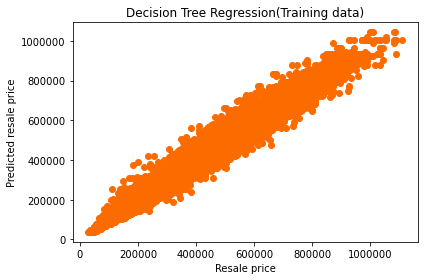

In [136]:
#plt.figure(figsize=(10,8))
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('Decision Tree Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./dt_4_cc_training_data.tiff",dpi=300)
plt.show()

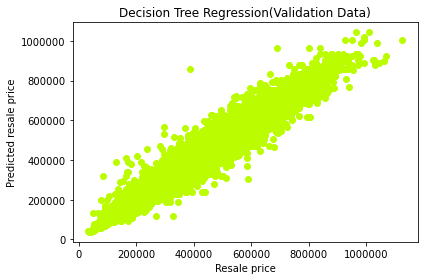

In [137]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('Decision Tree Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./dt_4_cc_validation_data.tiff",dpi=300)
plt.show()

In [138]:
dt_4_feature_importance = pd.DataFrame({'Feature':train_x.columns,'Importance':dt_4.feature_importances_}).sort_values('Importance', ascending=False)

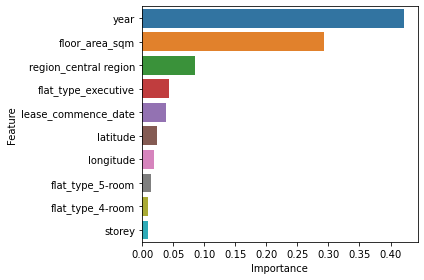

In [139]:
sns.barplot(y='Feature', x='Importance', data=dt_4_feature_importance.head(10))
plt.tight_layout()
plt.savefig("./dt_4_cc_feature_importance.tiff",dpi=300)

#### Uncomment next block to make prediction on test data and generate csv

In [140]:
#test_result = dt_3.predict(test_df)
#save_to_csv(test_result,"./mrt_dt_3_result.csv")

------------

## Random Forest

#### Train model using default hyperparameters

In [141]:
rf_1 = RandomForestRegressor()

In [142]:
%%time
rf_1.fit(train_x,train_y)

Wall time: 11min 41s


RandomForestRegressor()

In [143]:
train_prediction = rf_1.predict(train_x)
val_prediction = rf_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 6870.500649475857
Validation error(RMSE) : 18199.996675514198
R2 score for training data : 0.9972004023579591
R2 score for validation data : 0.9803730911429392


#### Modify max_depth and n_estimators and try next model

In [144]:
rf_2 = RandomForestRegressor(n_estimators=50,max_depth=10,n_jobs=-1,verbose=1)

In [145]:
%%time
rf_2.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


Wall time: 1min 56s


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, verbose=1)

In [146]:

train_prediction = rf_2.predict(train_x)
val_prediction = rf_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Training error(RMSE) : 32047.573650536193
Validation error(RMSE) : 32800.560366094935
R2 score for training data : 0.9390871166452456
R2 score for validation data : 0.9362512292273175


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


#### Modify max_depth and n_estimators and try next model

In [147]:
rf_3 = RandomForestRegressor(n_estimators=50,max_depth=50,n_jobs=-1,verbose=1)

In [148]:
%%time
rf_3.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min


Wall time: 2min 26s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=-1, verbose=1)

In [149]:
train_prediction = rf_3.predict(train_x)
val_prediction = rf_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished


Training error(RMSE) : 7027.772097414558
Validation error(RMSE) : 18306.30163040434
R2 score for training data : 0.9970707651811715
R2 score for validation data : 0.9801431426359234


#### Modify max_depth, n_estimators and max_features and try next model

In [150]:
rf_4 = RandomForestRegressor(n_estimators=50,max_depth=50,max_features=50,n_jobs=-1,verbose=1)

In [151]:
%%time
rf_4.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.2s


Wall time: 48.1 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.8s finished


RandomForestRegressor(max_depth=50, max_features=50, n_estimators=50, n_jobs=-1,
                      verbose=1)

In [152]:
train_prediction = rf_4.predict(train_x)
val_prediction = rf_4.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


Training error(RMSE) : 7373.457637208818
Validation error(RMSE) : 18930.472055317758
R2 score for training data : 0.9967755085632689
R2 score for validation data : 0.9787659822545043


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished


In [153]:
feature_importance_rf_4 = pd.DataFrame({'Feature':train_x.columns,'Importance':rf_4.feature_importances_}).sort_values('Importance', ascending=False)

In [154]:
feature_importance_rf_4.head(10)

,Feature,Importance
5,year,0.372472
0,floor_area_sqm,0.148836
37,flat_type_3-room,0.068943
1,lease_commence_date,0.061364
40,flat_type_executive,0.039518
2,latitude,0.038780
249,region_central region,0.035758
39,flat_type_5-room,0.034420
38,flat_type_4-room,0.024323
6,storey,0.024272


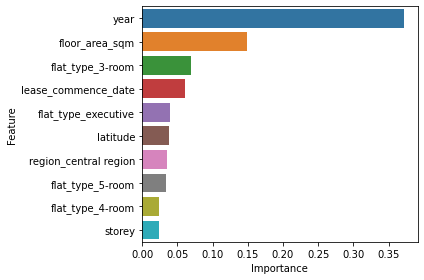

In [155]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_rf_4.head(10))
plt.tight_layout()
plt.savefig("./rf_4_cc_feature_importance.tiff",dpi=300)

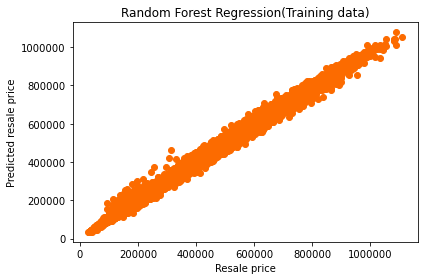

In [156]:
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
plt.title('Random Forest Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./rf_4_cc_training_data.tiff",dpi=300)
plt.show()

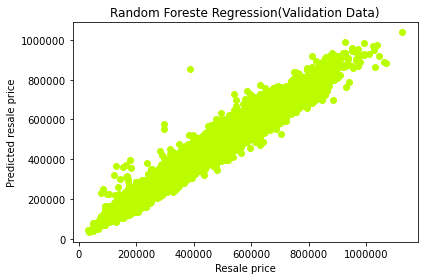

In [157]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('Random Foreste Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./rf_4_cc_validation_data.tiff",dpi=300)
plt.show()

#### Uncomment next block to make prediction on test data and generate csv

In [158]:
#test_result = rf_1.predict(test_df)
#save_to_csv(test_result,"./commercial_center_rf_1_result.csv")

-----------

## XGBOOST

#### Train model using default parameters

In [54]:
xgb_model_1 = xgboost.XGBRegressor()

In [55]:
%%time
xgb_model_1.fit(train_x,train_y)

Wall time: 48.7 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
train_prediction = xgb_model_1.predict(train_x)
val_prediction = xgb_model_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 21210.207
Validation error(RMSE) : 22012.209
R2 score for training data : 0.9733782873834333
R2 score for validation data : 0.9710304797033864


#### Modify hyperparameters and try next model

In [159]:
xgb_model_2 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=50,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [160]:
%%time
xgb_model_2.fit(train_x,train_y)

Wall time: 4min 1s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=50,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [161]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 10102.929
Validation error(RMSE) : 22206.865
R2 score for training data : 0.9939464035370816
R2 score for validation data : 0.9707797560715188


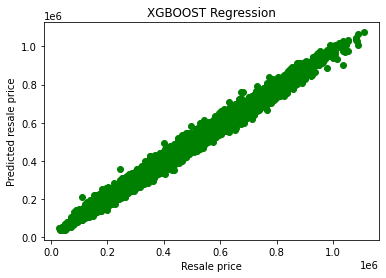

In [162]:
plt.scatter(train_y,train_prediction, color = 'green')
plt.title('XGBOOST Regression')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.show()

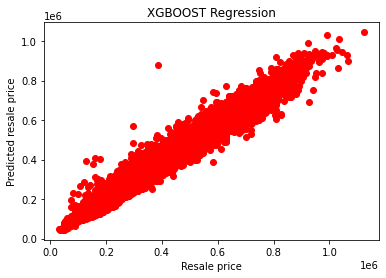

In [163]:
plt.scatter(val_y,val_prediction, color = 'red')
plt.title('XGBOOST Regression')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.show()

#### Uncomment next block to make prediction on test data and generate csv

In [60]:
#test_result = xgb_model_2.predict(test_df)
#save_to_csv(test_result,"./commercial_center_xgb_model_2_result.csv")

-----------

## LightGBM

#### Train model using default parameter

In [164]:
gbm_1 = lgb.LGBMRegressor()

In [165]:
%%time
gbm_1 = gbm_1.fit(train_x,train_y)

Wall time: 2.57 s


In [114]:
train_prediction = gbm_1.predict(train_x)
val_prediction = gbm_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 24360.60860771825
Validation error(RMSE) : 24521.02290559277
R2 score for training data : 0.9648226462678352
R2 score for validation data : 0.9642971517490999


#### Modify learning_rate, max_depth and n_estimators and try next model

In [78]:
gbm_2 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=10000,n_estimators=10000)

In [79]:
%%time
gbm_2 = gbm_2.fit(train_x,train_y)

Wall time: 51.7 s


In [80]:
train_prediction = gbm_2.predict(train_x)
val_prediction = gbm_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11671.301878284024
Validation error(RMSE) : 15991.739470076684
R2 score for training data : 0.9919363554259226
R2 score for validation data : 0.9847310103804655


In [81]:
feature_importance_gbm_2 = pd.DataFrame({'Feature':train_x.columns,'Importance':gbm_2.feature_importances_}).sort_values('Importance', ascending=False)

In [82]:
feature_importance_gbm_2.head(10)

,Feature,Importance
5,year,62730
0,floor_area_sqm,39571
4,month_no,36256
7,nearest_commercial_center_distance,34118
2,latitude,28433
6,storey,25655
3,longitude,23403
1,lease_commence_date,14704
38,flat_type_4-room,2220
49,flat_model_model a,1833


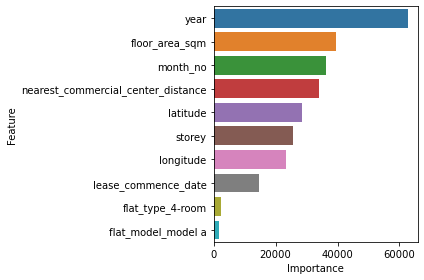

In [166]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_gbm_2.head(10))
plt.tight_layout()
plt.savefig("./gbm_2_cc_feature_importance.tiff",dpi=300)

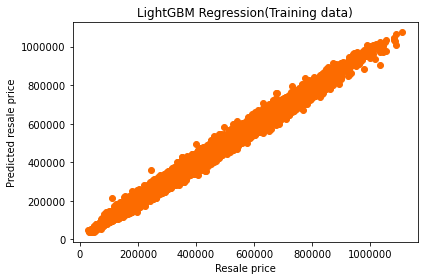

In [167]:
#plt.figure(figsize=(10,8))
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('LightGBM Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./gbm_2_cc_training_data.tiff",dpi=300)
plt.show()

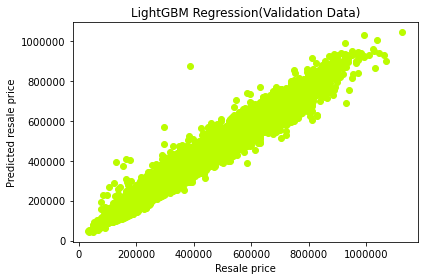

In [168]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('LightGBM Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./gbm_2_cc_validation_data.tiff",dpi=300)
plt.show()

#### Modify learning_rate, max_depth and n_estimators and try next model

In [123]:
gbm_3 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=5000,n_estimators=5000)

In [124]:
gbm_3.fit(
    train_x, train_y, 
    eval_set= [(train_x, train_y), (val_x, val_y)], 
    eval_metric='rmse', verbose=1000)

[1000]	training's rmse: 16970.2	training's l2: 2.87986e+08	valid_1's rmse: 17720.7	valid_1's l2: 3.14023e+08
[2000]	training's rmse: 15569.7	training's l2: 2.42417e+08	valid_1's rmse: 16853.5	valid_1's l2: 2.8404e+08
[3000]	training's rmse: 14737.1	training's l2: 2.17182e+08	valid_1's rmse: 16496.7	valid_1's l2: 2.7214e+08
[4000]	training's rmse: 14126	training's l2: 1.99543e+08	valid_1's rmse: 16335.9	valid_1's l2: 2.66863e+08
[5000]	training's rmse: 13666.5	training's l2: 1.86773e+08	valid_1's rmse: 16247.5	valid_1's l2: 2.63982e+08


LGBMRegressor(max_depth=5000, n_estimators=5000)

In [125]:
train_prediction = gbm_3.predict(train_x)
val_prediction = gbm_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13666.479985769194
Validation error(RMSE) : 16247.52497414169
R2 score for training data : 0.9889286587568709
R2 score for validation data : 0.9843252679928246


#### Uncomment next block to make prediction on test data and generate csv

In [86]:
#test_result = gbm_2.predict(test_df)
#save_to_csv(test_result,"./commercial_center_gbm_2_result_longitude.csv")

-----------

## Prediction using Random Forest, XGBOOST and LightGBM together

In [68]:
train_prediction = 0.4*gbm_2.predict(train_x) + 0.4*rf_1.predict(train_x) +0.2*xgb_model_2.predict(train_x)
val_prediction = 0.4*gbm_2.predict(val_x)+ 0.4*rf_1.predict(val_x) +0.2*xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 9154.548507004409
Validation error(RMSE) : 16732.97969155876
R2 score for training data : 0.9950407040974742
R2 score for validation data : 0.9832598013969583


#### Uncomment next block to make prediction on test data and generate csv

In [69]:
test_result = 0.4*gbm_2.predict(test_df) + 0.4*rf_1.predict(test_df) +0.2*xgb_model_2.predict(test_df)
save_to_csv(test_result,"./commercial_center_gbm_2_xgb_model_2_rf_1_result.csv")